# Random-graph UD-MIS (Classical)

$$
H = -\sum_{i \in V} n_i + u \sum_{i,j \in E} n_i n_j
$$

Our goal is to find one of the ground state(s) - a solution to the UD-MIS problem - automatically through Monte Carlo sampling.

The probability distribution of the Ising model at temperature $T$ is given by the Gibbs distribution:

$$p(\sigma; T) = \frac{1}{Z(T)}\exp\left(-\frac{H(\sigma)}{T}\right)$$,

where $Z(T)$ is the normalization constant (also known as the *partition function*).

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from abstract_udmis import AbstractUDMIS

%matplotlib inline

Below you'll find code for the UDMIS model of interest. Strictly speaking, for the purposes of performing the Monte Carlo simulation we can simply compute the required energy differences using two calls to the energy function. However, we can often save significant computation time by writing a specialised function for the energy difference that avoids unnecessary calculations. Simply put, calculating the energy of a configuration of occupations requires you to iterate over all vertices in the graph, but the energy change associated with a single-occupation-flip can be computed just from values of the connected vertices.

In [2]:
class UDMIS(AbstractUDMIS):
    def __init__(self, u, graph):
        super().__init__()
        self.u, self.graph = u, graph
        self.num_vertices = len(self.graph)
        print(self.num_vertices)
        # initialize system at infinite temperature
        # i.e. vertices are completely random and uncorrelated
        self.occupations = np.random.rand(self.num_vertices) < 0.5
        self.edges = self.find_edges()
    
    def find_edges(self):
        #num_pairs = int(self.num_vertices*(self.num_vertices)*0.5)
        edges = np.zeros((self.num_vertices, self.num_vertices), dtype=bool)
        
        for i in range(self.num_vertices-1):
            x_i, y_i = graph[i] # these are the x, y coordinates of the i'th vertex in the graph
            for j in range(i+1, self.num_vertices):
                x_j, y_j = graph[j] # these are the x, y coordinates of the j'th vertex in the graph
                
                # calculate the distance between vertices
                dij = np.sqrt((x_i - x_j)**2. + (y_i - y_j)**2.)
                if dij <= 1.0:
                    edges[i,j] = True
                    edges[j,i] = True
                    
        return edges
        
    def energy(self):
        """Returns the energy of the current spin configuration"""
        # interaction term
        interaction_term = 0
        vertex_term = 0
        for i in range(self.num_vertices-1):
            for j in range(i+1, self.num_vertices):
                
                # check if there is an edge
                if self.edges[i,j]:
                    interaction_term += self.occupations[i]*self.occupations[j]
                
            vertex_term += self.occupations[i]
        
        # missed the last vertex
        vertex_term += self.occupations[self.num_vertices-1]
    
        return u*interaction_term - vertex_term

    def energy_diff(self, i):
        connections = np.where(self.edges[i,:])[0]
        num_adjacent_occupied = sum(self.occupations[connections])
        
        if self.occupations[i] == 1:
            # flipping an occupied vertex increases the vertex term, decreases the interaction term
            vertex_term_change = 1.
            interaction_term_change = -u*num_adjacent_occupied
        
        elif self.occupations[i] == 0:
            # flipping an unoccupied vertex decreases the vertex term, increases the interaction term
            vertex_term_change = -1.
            interaction_term_change = u*num_adjacent_occupied 

        return interaction_term_change + vertex_term_change
    
    def rand_vertex(self):
        """Selects a site in the graph at random"""
        return np.random.randint(self.num_vertices)        

In [3]:
u = 1.35
graph = [(0.3461717838632017, 1.4984640297338632), 
         (0.6316400411846113, 2.5754677320579895), 
         (1.3906262250927481, 2.164978861396621), 
         (0.66436005100802, 0.6717919819739032), 
         (0.8663329771713457, 3.3876341010035995), 
         (1.1643107343501296, 1.0823066243402013)
        ]

udmis = UDMIS(u, graph)

6


In [4]:
N = 5000
t = np.arange(N+1)
T_i = 100
T_f = 0.01

T = T_i * ((T_f/T_i) ** (t/N))

for t in range(N):
    # take a look at the abstract_udmis.py file to see how mc_step works
    temp = T[t]
    E = udmis.mc_step(T=temp)
    
    if t % 100 == 0:
        print(t, E, udmis.occupations)

0 0.7500000000000004 [ True  True  True  True  True  True]
100 -3.0 [False False  True  True  True False]
200 -2.65 [ True False  True  True  True False]
300 -1.2999999999999998 [ True  True  True False  True False]
400 -1.65 [False  True False  True  True False]
500 -1.0 [False False  True False False False]
600 -1.2999999999999998 [ True  True False False  True  True]
700 -1.2999999999999998 [ True  True  True  True False False]
800 -1.2999999999999998 [False  True False  True  True  True]
900 -2.0 [False  True False  True False False]
1000 -1.65 [False False  True  True False  True]
1100 -0.2999999999999998 [False  True  True False  True False]
1200 0.050000000000000266 [ True False  True  True False  True]
1300 -1.6499999999999995 [False  True  True  True False False]
1400 -1.2999999999999998 [False  True  True False  True  True]
1500 -2.0 [False False False False  True  True]
1600 -0.9499999999999997 [ True False  True  True  True  True]
1700 -3.0 [False False  True False  True  T

## Solution for Task 1 

We test various annealing schedules and compare the time it takes to reach a solution to the UD-MIS problem. We define an arbitrary threshold of the number of consecutive energies needed to be considered a solution (for example, if we define `threshold=100`, we need 100 consecutive energies to be the same to consider it a solution). Then we are able to plot the number of iterations needed to achieve a solution. 

We compared 3 functions: 
1. T_i * ((T_f/T_i) ** (t/N))        (this is the benchmark provided in the sample code)
2. T_i * ((T_f/T_i) ** (2*t/N))
3. T_i * ((T_f/T_i) ** (4*t/N))

Intuitively function 3 should yield the fastest convergence because it decreases the temperature the fastest. From our results, we see that this is indeed correct with the following iterations needed to reach convergence respectively (at a threshold of 100):

1. 3798 iterations
2. 2067 iterations
3. 1016 iterations

> Starting experiment for cooling schedule: exponential ~x (benchmark)
Found solution:  3798 -3.0 [False False  True  True  True False]
> Starting experiment for cooling schedule: exponential ~2x
Found solution:  2067 -3.0 [False False  True  True  True False]
> Starting experiment for cooling schedule: exponential ~4x
Found solution:  1016 -3.0 [ True False  True False  True False]


Text(0.5, 1.0, 'Stable Energies for Various Annealing Schedules')

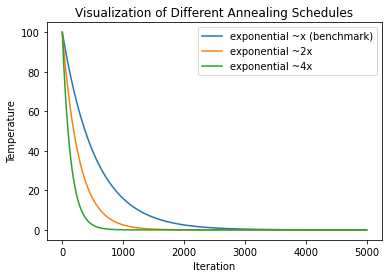

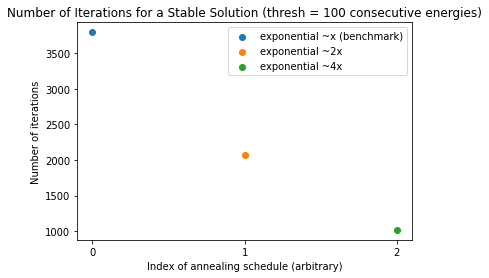

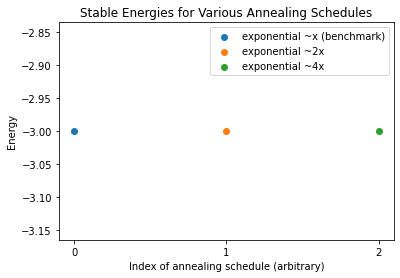

In [5]:
N = 5000
t = np.arange(N+1)
T_i = 100
T_f = 0.01
threshold = 100  # consider "threshold" (i.e. 100) repeated experiments with the same energy a solution

# ------------------- Define schedules you want to play with here
schedules = [
    T_i * ((T_f/T_i) ** (t/N)),  # benchmark
    T_i * ((T_f/T_i) ** (2*t/N)),  # Increasing temperature faster (by factor of 2)
    T_i * ((T_f/T_i) ** (4*t/N)),  # Increasing temperature even faster (by factor of 4)
]

# Name of the schedule (should be same length as "schedules" variable)
legends = [
    'exponential ~x (benchmark)',
    'exponential ~2x',
    'exponential ~4x',
]
# ------------------- End schedule definition

solution_iterations = np.zeros(len(schedules))  # this will hold the number of iterations needed to arrive at a "solution" given "threshold" number of consecutive energies
solution_energies = np.zeros(len(schedules))

# Plot these schedules
for schedule in schedules:
    plt.plot(t, schedule)
plt.legend(legends)
plt.title('Visualization of Different Annealing Schedules')
plt.xlabel('Iteration')
plt.ylabel('Temperature')

for idx, (legend, schedule) in enumerate(zip(legends, schedules)):
    print(f'> Starting experiment for cooling schedule: {legend}')
    energies = np.zeros(N)
    for t in range(N):
        # take a look at the abstract_udmis.py file to see how mc_step works
        temp = schedule[t]
        E = udmis.mc_step(T=temp)
        
        energies[t] = E

        if (t > threshold and np.all(energies[t-threshold: t] == E)):
            # found solution
            print(f'Found solution: ', t, E, udmis.occupations)
            solution_iterations[idx] = t
            solution_energies[idx] = E
            break

        # if t % 100 == 0:
        #     print(t, E, udmis.occupations)

# Plot the results (number of iterations until stable solution)
plt.figure()
for idx, solution_it in enumerate(solution_iterations):
    plt.scatter(idx, [solution_it])
plt.legend(legends)
plt.xticks(np.arange(len(legends)))
plt.xlabel('Index of annealing schedule (arbitrary)')
plt.ylabel(f'Number of iterations')
plt.title(f'Number of Iterations for a Stable Solution (thresh = {threshold} consecutive energies)')

# Plot the energies found at the stable solutions
plt.figure()
for idx, solution_energy in enumerate(solution_energies):
    plt.scatter(idx, [solution_energy])
plt.legend(legends)
plt.xticks(np.arange(len(legends)))
plt.xlabel('Index of annealing schedule (arbitrary)')
plt.ylabel(f'Energy')
plt.title('Stable Energies for Various Annealing Schedules')

